In [213]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pre_processing
import nltk
# nltk.download('punkt')
from nltk import word_tokenize
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_auc_score
%matplotlib notebook

In [214]:
%matplotlib notebook

## Pre Processing

In [215]:
df_adm_notes_clean = pre_processing.load_clean_merge_dataset('/Users/harnoor_dhingra/Desktop/Project RL Sepsis/Datasets/Mimic/Working/mimic-iii-clinical-database-1.4/ADMISSIONS.csv','/Users/harnoor_dhingra/Desktop/Project RL Sepsis/Datasets/Mimic/Working/mimic-iii-clinical-database-1.4/NOTEEVENTS.csv')

/Users/harnoor_dhingra/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3325: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [216]:
df_adm_notes_clean['CHECK'] = (df_adm_notes_clean.DAYS_NEXT_ADMIT < 30).astype('int') #add the column for the value if the patient is admitted again with a month(30 days)

In [217]:
print('Number of patients who got admitted again within a month:', (df_adm_notes_clean.CHECK == 1).sum())
print('Number of patients who got admitted again within a month::',  (df_adm_notes_clean.CHECK == 0).sum())
print('Total samples:', len(df_adm_notes_clean))

Number of patients who got admitted again within a month: 3004
Number of patients who got admitted again within a month:: 48109
Total samples: 51113


<IPython.core.display.Javascript object>


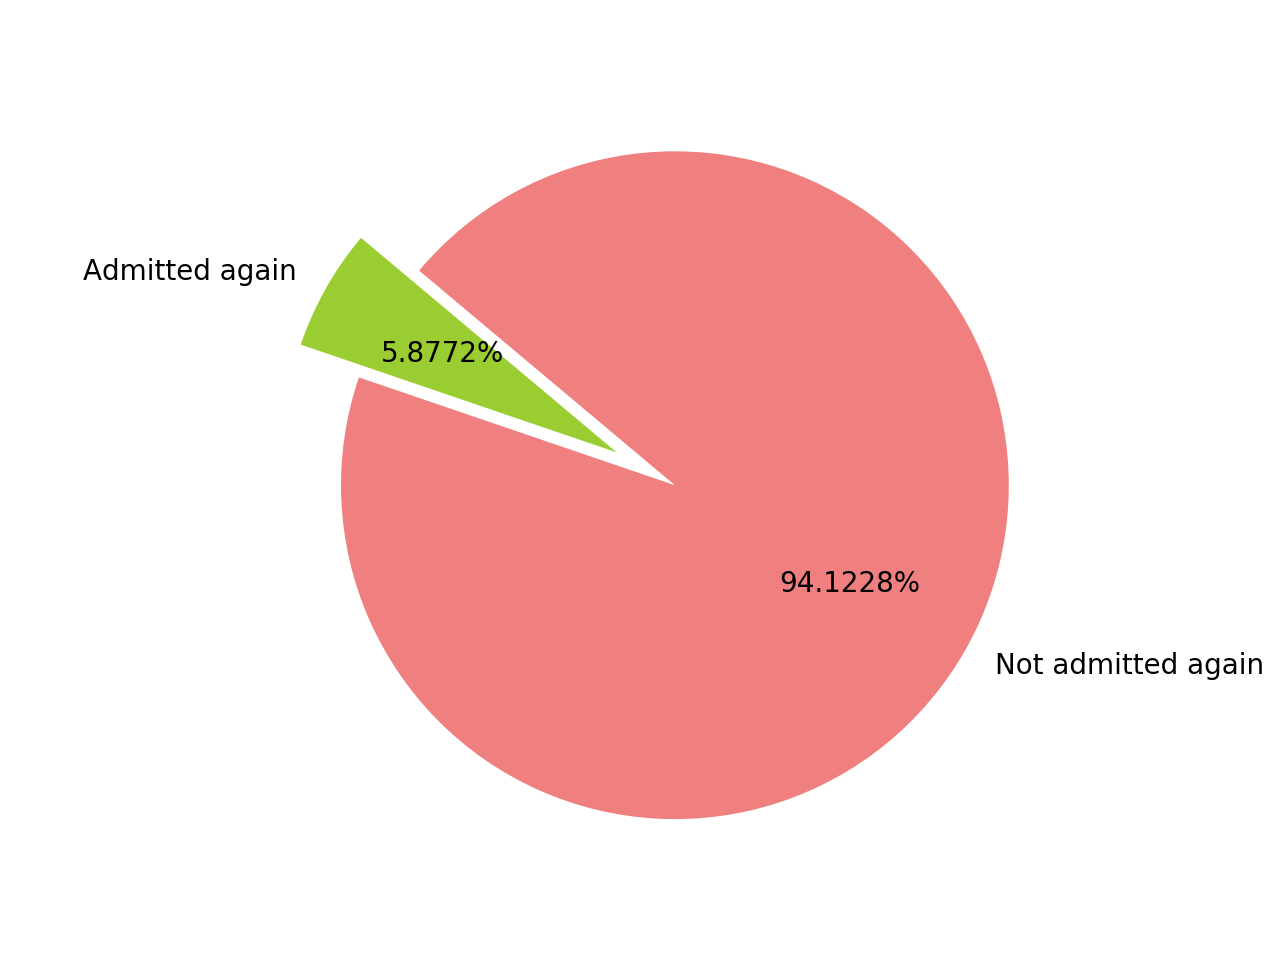

In [218]:
fig = plt.figure()
labels = ['Admitted again', 'Not admitted again']
sizes = [(df_adm_notes_clean.CHECK == 1).sum(), (df_adm_notes_clean.CHECK == 0).sum()]
colors = ['yellowgreen', 'lightcoral']
explode = [0.2,0]
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%4.4f%%', shadow=False, startangle=140)
plt.axis('equal')
plt.show()

In [219]:
df_adm_notes_clean = df_adm_notes_clean.sample(n = len(df_adm_notes_clean), random_state = 42)
df_adm_notes_clean = df_adm_notes_clean.reset_index(drop = True)
df_valid_test=df_adm_notes_clean.sample(frac=0.30,random_state=42)
df_test = df_valid_test.sample(frac = 0.5, random_state = 42)
df_valid = df_valid_test.drop(df_test.index)
df_train_all = df_adm_notes_clean.drop(df_valid_test.index)

In [220]:
print('Test Prevalence(n = %d):%.4f'%(len(df_test),df_test.CHECK.sum()/ len(df_test)))
print('Valid Prevalence(n = %d):%.4f'%(len(df_valid),df_valid.CHECK.sum()/ len(df_valid)))
print('Train all Prevalence(n = %d):%.4f'%(len(df_train_all), df_train_all.CHECK.sum()/ len(df_train_all)))
print('all samples (n = %d)'%len(df_adm_notes_clean))
assert len(df_adm_notes_clean) == (len(df_test)+len(df_valid)+len(df_train_all)),'wrong'

Test Prevalence(n = 7667):0.0620
Valid Prevalence(n = 7667):0.0570
Train all Prevalence(n = 35779):0.0585
all samples (n = 51113)


<IPython.core.display.Javascript object>


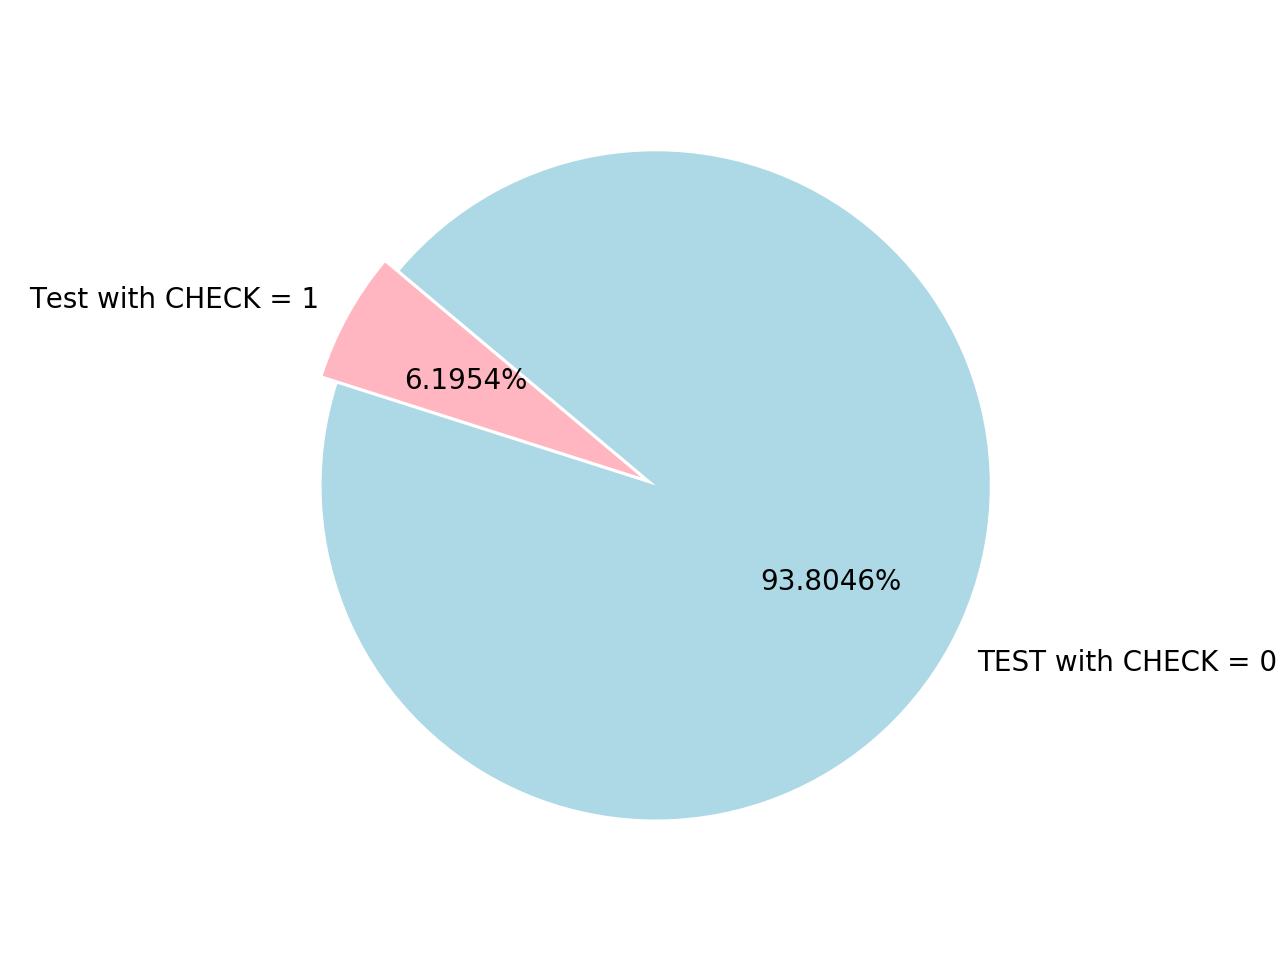

In [221]:
fig = plt.figure()
labels = ['Test with CHECK = 1', 'TEST with CHECK = 0']
sizes = [df_test.CHECK.sum(), len(df_test) - df_test.CHECK.sum()]
colors = ['lightpink', 'lightblue']
explode = [0.05,0]
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%4.4f%%', shadow=False, startangle=140)
plt.axis('equal')
plt.show()

<IPython.core.display.Javascript object>


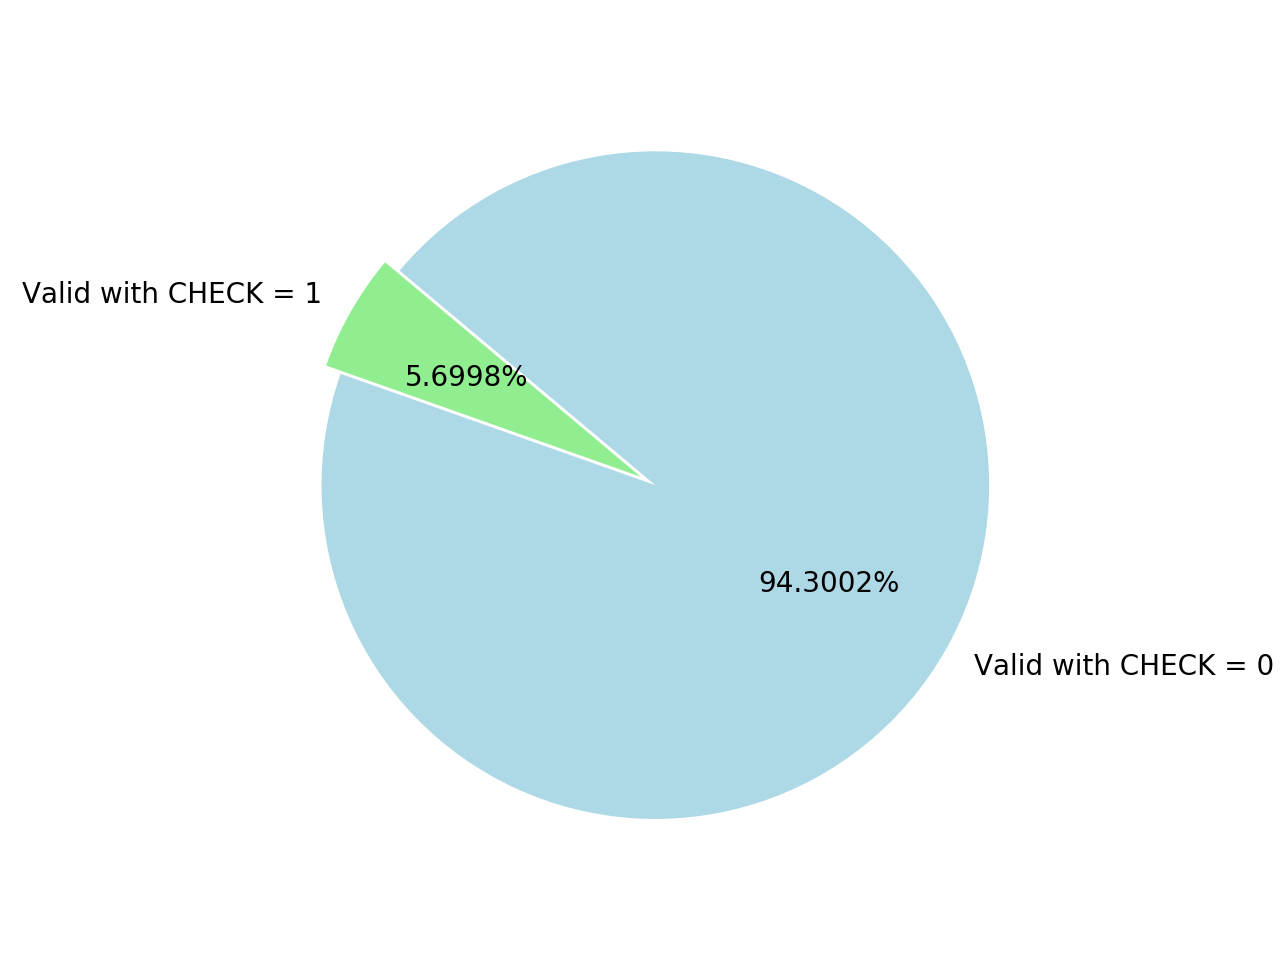

In [222]:
fig = plt.figure()
labels = ['Valid with CHECK = 1', 'Valid with CHECK = 0']
sizes = [df_valid.CHECK.sum(), len(df_valid) - df_valid.CHECK.sum()]
colors = ['lightgreen', 'lightblue']
explode = [0.05,0]
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%4.4f%%', shadow=False, startangle=140)
plt.axis('equal')
plt.show()

<IPython.core.display.Javascript object>


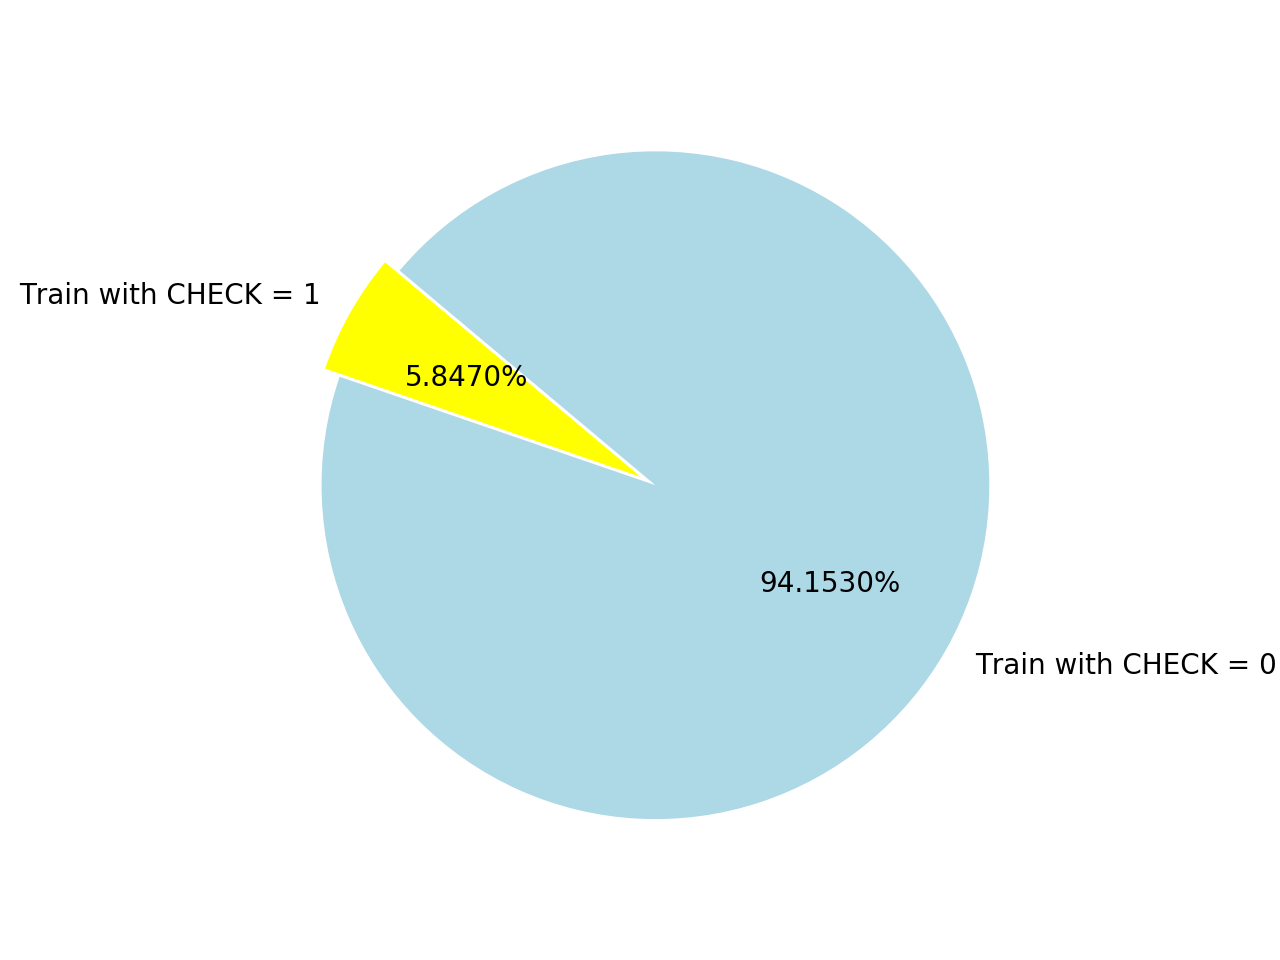

In [223]:
fig = plt.figure()
labels = ['Train with CHECK = 1', 'Train with CHECK = 0']
sizes = [df_train_all.CHECK.sum(), len(df_train_all) - df_train_all.CHECK.sum()]
colors = ['yellow', 'lightblue']
explode = [0.05,0]
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%4.4f%%', shadow=False, startangle=140)
plt.axis('equal')
plt.show()

In [224]:
df_train_all.to_csv('/Users/harnoor_dhingra/Desktop/Project RL Sepsis/Datasets/Mimic/Working/mimic-iii-clinical-database-1.4/df_train_all.csv',index=False)
df_valid.to_csv('/Users/harnoor_dhingra/Desktop/Project RL Sepsis/Datasets/Mimic/Working/mimic-iii-clinical-database-1.4/df_valid.csv',index=False)
df_test.to_csv('/Users/harnoor_dhingra/Desktop/Project RL Sepsis/Datasets/Mimic/Working/mimic-iii-clinical-database-1.4/df_test.csv',index=False)

In [225]:
df_test = pd.read_csv('/Users/harnoor_dhingra/Desktop/Project RL Sepsis/Datasets/Mimic/Working/mimic-iii-clinical-database-1.4/df_test.csv') 
df_valid = pd.read_csv('/Users/harnoor_dhingra/Desktop/Project RL Sepsis/Datasets/Mimic/Working/mimic-iii-clinical-database-1.4/df_valid.csv') 
df_train_all= pd.read_csv('/Users/harnoor_dhingra/Desktop/Project RL Sepsis/Datasets/Mimic/Working/mimic-iii-clinical-database-1.4/df_train_all.csv') 
print('Valid Prevalence(n = %d):'%len(df_valid),df_valid.CHECK.sum()/ len(df_valid))
print('Train all Prevalence(n = %d):'%len(df_train_all), df_train_all.CHECK.sum()/ len(df_train_all))

Valid Prevalence(n = 7667): 0.056997521846876224
Train all Prevalence(n = 35779): 0.05847005226529529


In [226]:
rows_pos = df_train_all.CHECK == 1
df_train_pos = df_train_all.loc[rows_pos]
df_train_neg = df_train_all.loc[~rows_pos]
n = np.min([len(df_train_pos),len(df_train_neg)])
df_train = pd.concat([df_train_pos.sample(n = n, random_state = 42),df_train_neg.sample(n = n, random_state = 42)],axis = 0)
df_train = df_train.sample(n = len(df_train), random_state = 42).reset_index(drop = True)
print('Train Prevalence (n = %d):'%len(df_train), df_train.CHECK.sum()/ len(df_train))

Train Prevalence (n = 4184): 0.5


In [227]:
df_train.to_csv('/Users/harnoor_dhingra/Desktop/Project RL Sepsis/Datasets/Mimic/Working/mimic-iii-clinical-database-1.4/df_train.csv',index=False)

In [228]:
df_train = pd.read_csv('/Users/harnoor_dhingra/Desktop/Project RL Sepsis/Datasets/Mimic/Working/mimic-iii-clinical-database-1.4/df_train.csv')

## Notes Pre Processing

In [229]:
def preprocess_text(df):
    df.TEXT = df.TEXT.fillna(' ')
    df.TEXT =df.TEXT.str.replace('\n',' ')
    df.TEXT =df.TEXT.str.replace('\r',' ')
    return df

In [230]:
df_train = preprocess_text(df_train)
df_valid = preprocess_text(df_valid)
df_test = preprocess_text(df_test)

In [231]:
word_tokenize('Tial1, trial 2, t r i a l 3, 12538, *!@_-+=')

['Tial1',
 ',',
 'trial',
 '2',
 ',',
 't',
 'r',
 'i',
 'a',
 'l',
 '3',
 ',',
 '12538',
 ',',
 '*',
 '!',
 '@',
 '_-+=']

In [232]:
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [233]:
def tokenizer_two(text):
    punc_list = string.punctuation+'0123456789'
    t = str.maketrans(dict.fromkeys(punc_list, " "))
    text = text.lower().translate(t)
    tokens = word_tokenize(text)
    return tokens

In [234]:
tokenizer_two('Tial1, trial 2, t r i a l 3, 12538, *!@_-+=')

['tial', 'trial', 't', 'r', 'i', 'a', 'l']

In [235]:
sample_text = ['Trial 1 is a sentence', 
               'MIMIC dataset', 
               'New day is a new day haha']

In [236]:
vect = CountVectorizer(tokenizer = tokenizer_two)
vect.fit(sample_text)
X = vect.transform(sample_text)

In [237]:
X

<3x9 sparse matrix of type '<class 'numpy.int64'>'
	with 11 stored elements in Compressed Sparse Row format>

In [238]:
X.toarray()

array([[1, 0, 0, 0, 1, 0, 0, 1, 1],
       [0, 1, 0, 0, 0, 1, 0, 0, 0],
       [1, 0, 2, 1, 1, 0, 2, 0, 0]])

In [239]:
vect.get_feature_names()

['a', 'dataset', 'day', 'haha', 'is', 'mimic', 'new', 'sentence', 'trial']

In [241]:
vect = CountVectorizer(max_features = 3000, tokenizer = tokenizer_two)
vect.fit(df_train.TEXT.values)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=3000, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function tokenizer_two at 0x16d468f28>,
                vocabulary=None)

Source: https://www.linkedin.com/pulse/another-twitter-sentiment-analysis-python-part-2-ricky-kim/

In [243]:
neg_doc_matrix = vect.transform(df_train[df_train.CHECK == 0].TEXT)
pos_doc_matrix = vect.transform(df_train[df_train.CHECK == 1].TEXT)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df = pd.DataFrame([neg,pos],columns=vect.get_feature_names()).transpose()
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

,negative,positive,total
the,71054,76756,147810
and,62455,71658,134113
to,53226,62085,115311
of,51303,60491,111794
was,48074,53521,101595
with,38036,44583,82619
a,35428,41629,77057
on,32290,39765,72055
mg,27718,39045,66763
in,29567,34755,64322


<IPython.core.display.Javascript object>


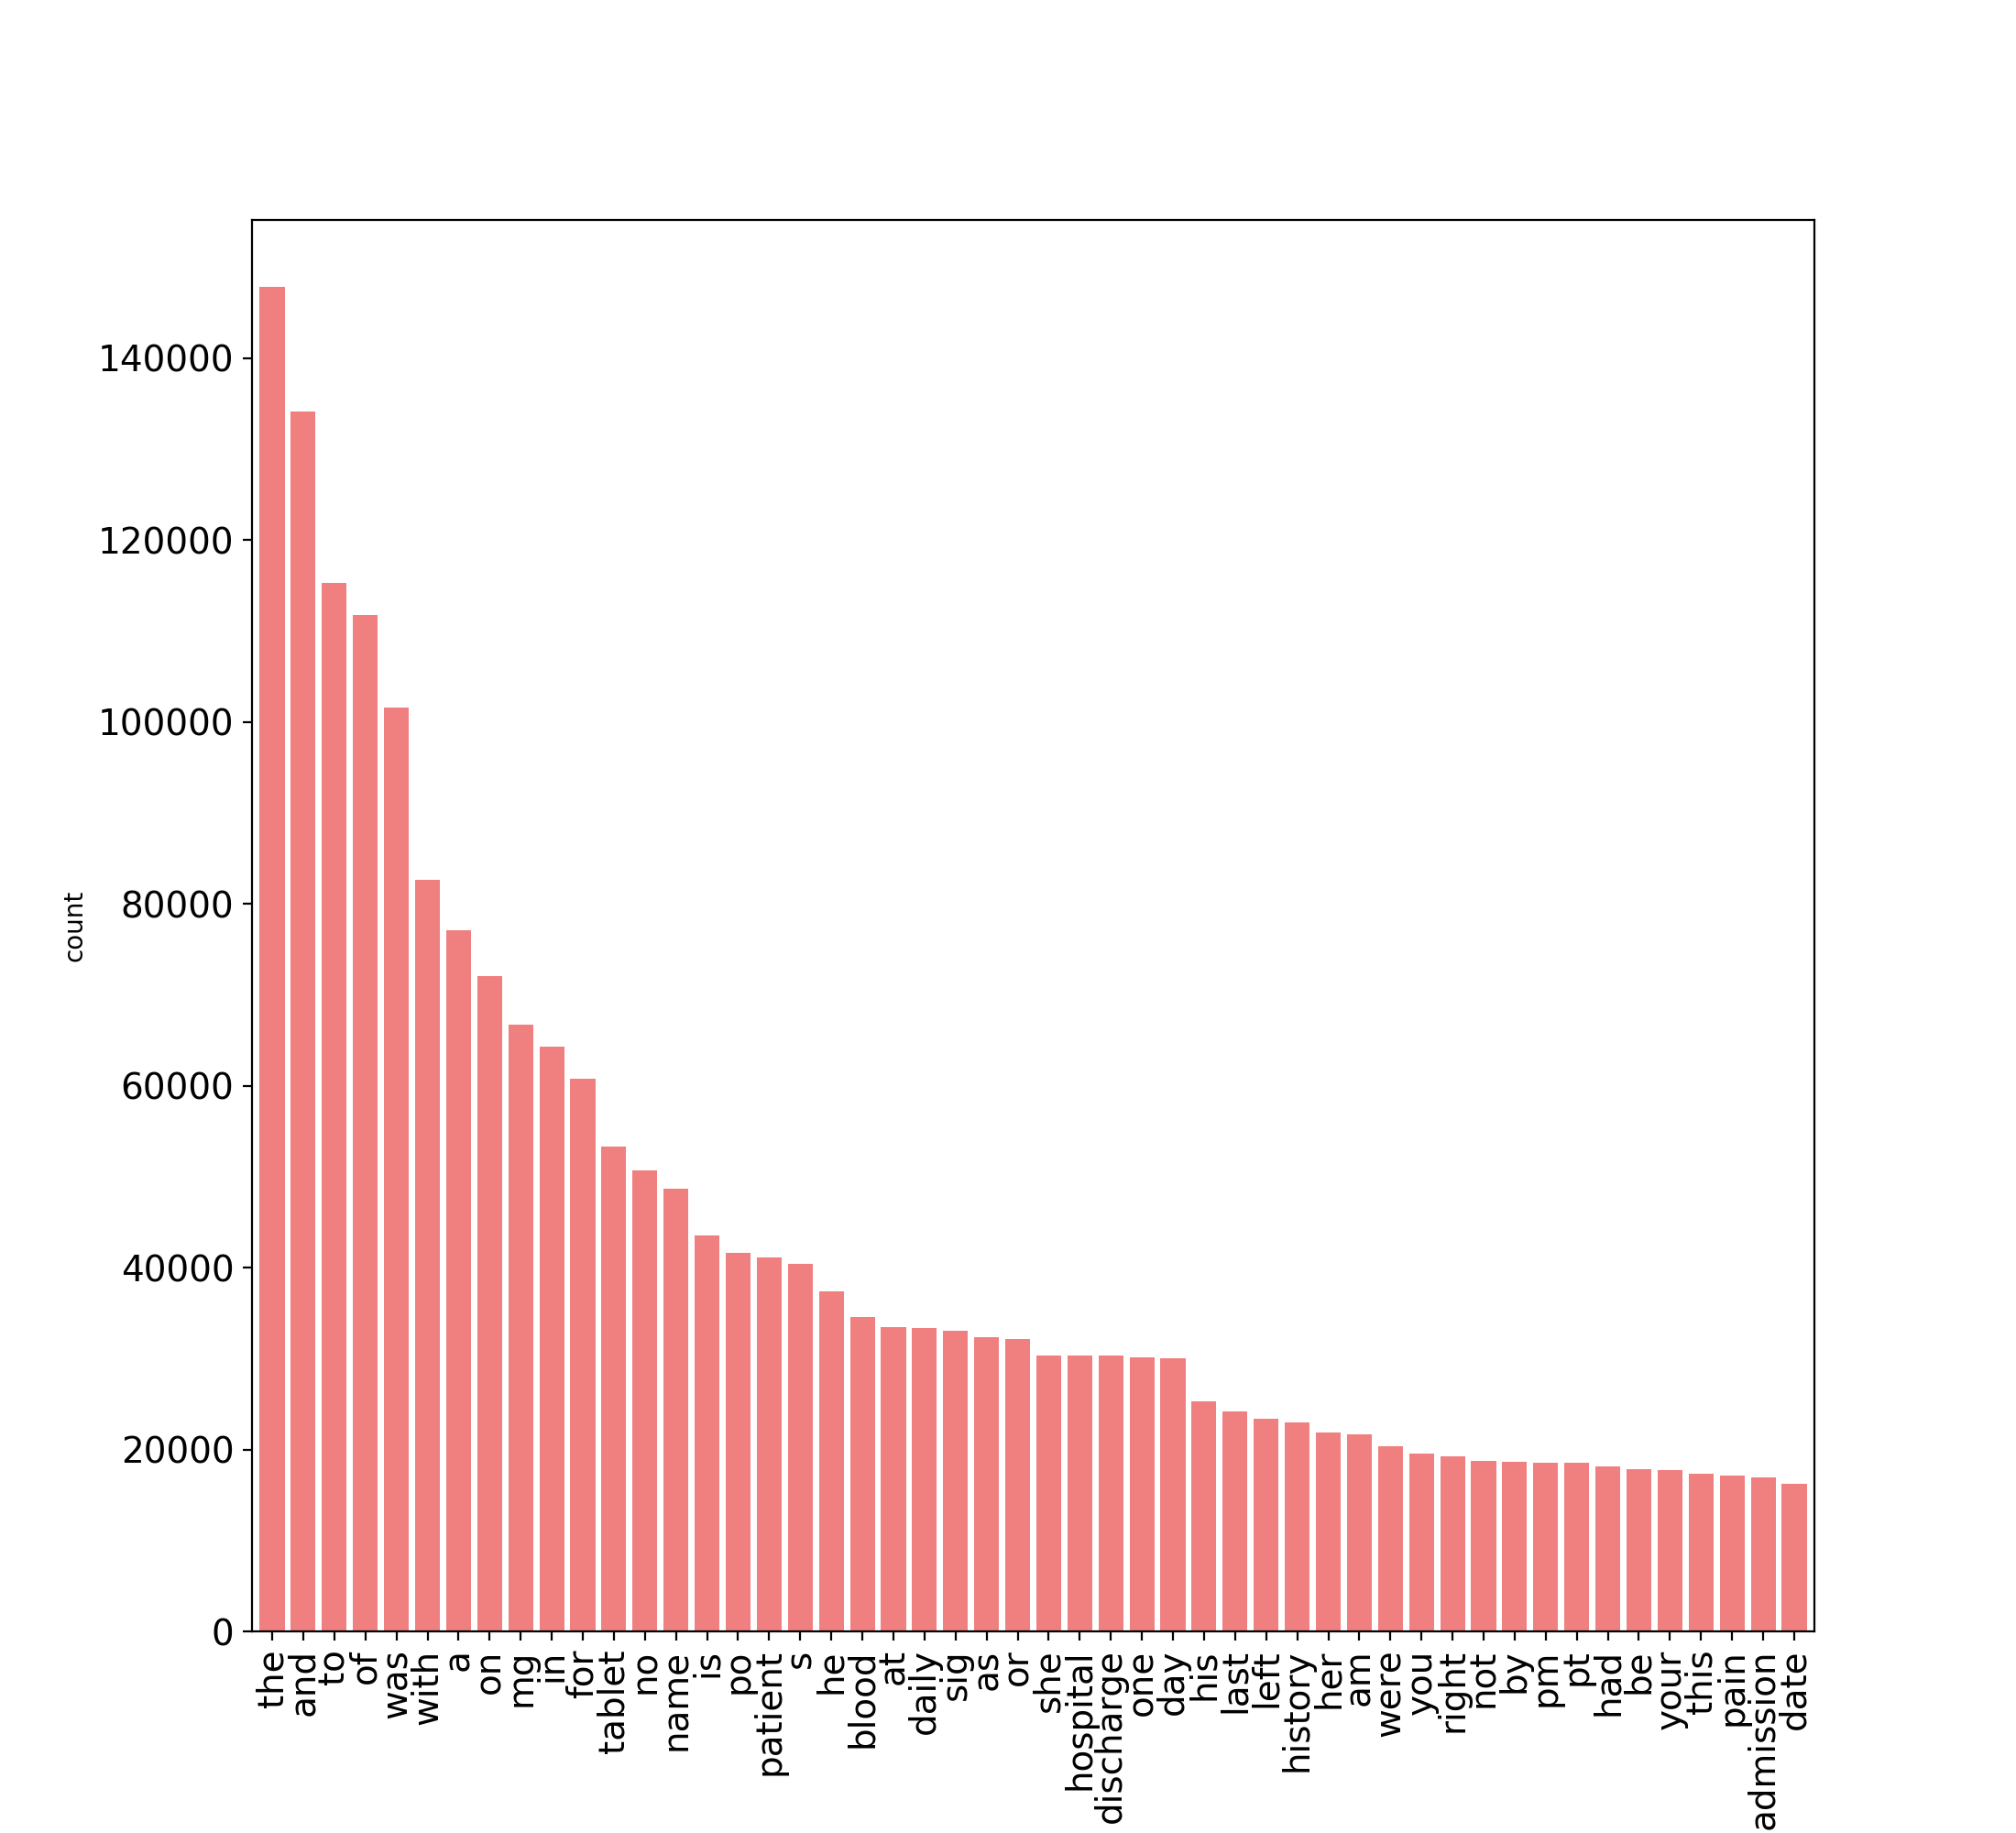

In [248]:
d = pd.Series(term_freq_df.total, index = term_freq_df.index).sort_values(ascending=False)
fig = plt.figure()
ax = d[:50].plot(kind='bar', figsize=(11,10), width=.8, fontsize=14, rot=90,color = 'lightcoral')
ax.title.set_size(18)
plt.ylabel('count')
plt.show()

<IPython.core.display.Javascript object>


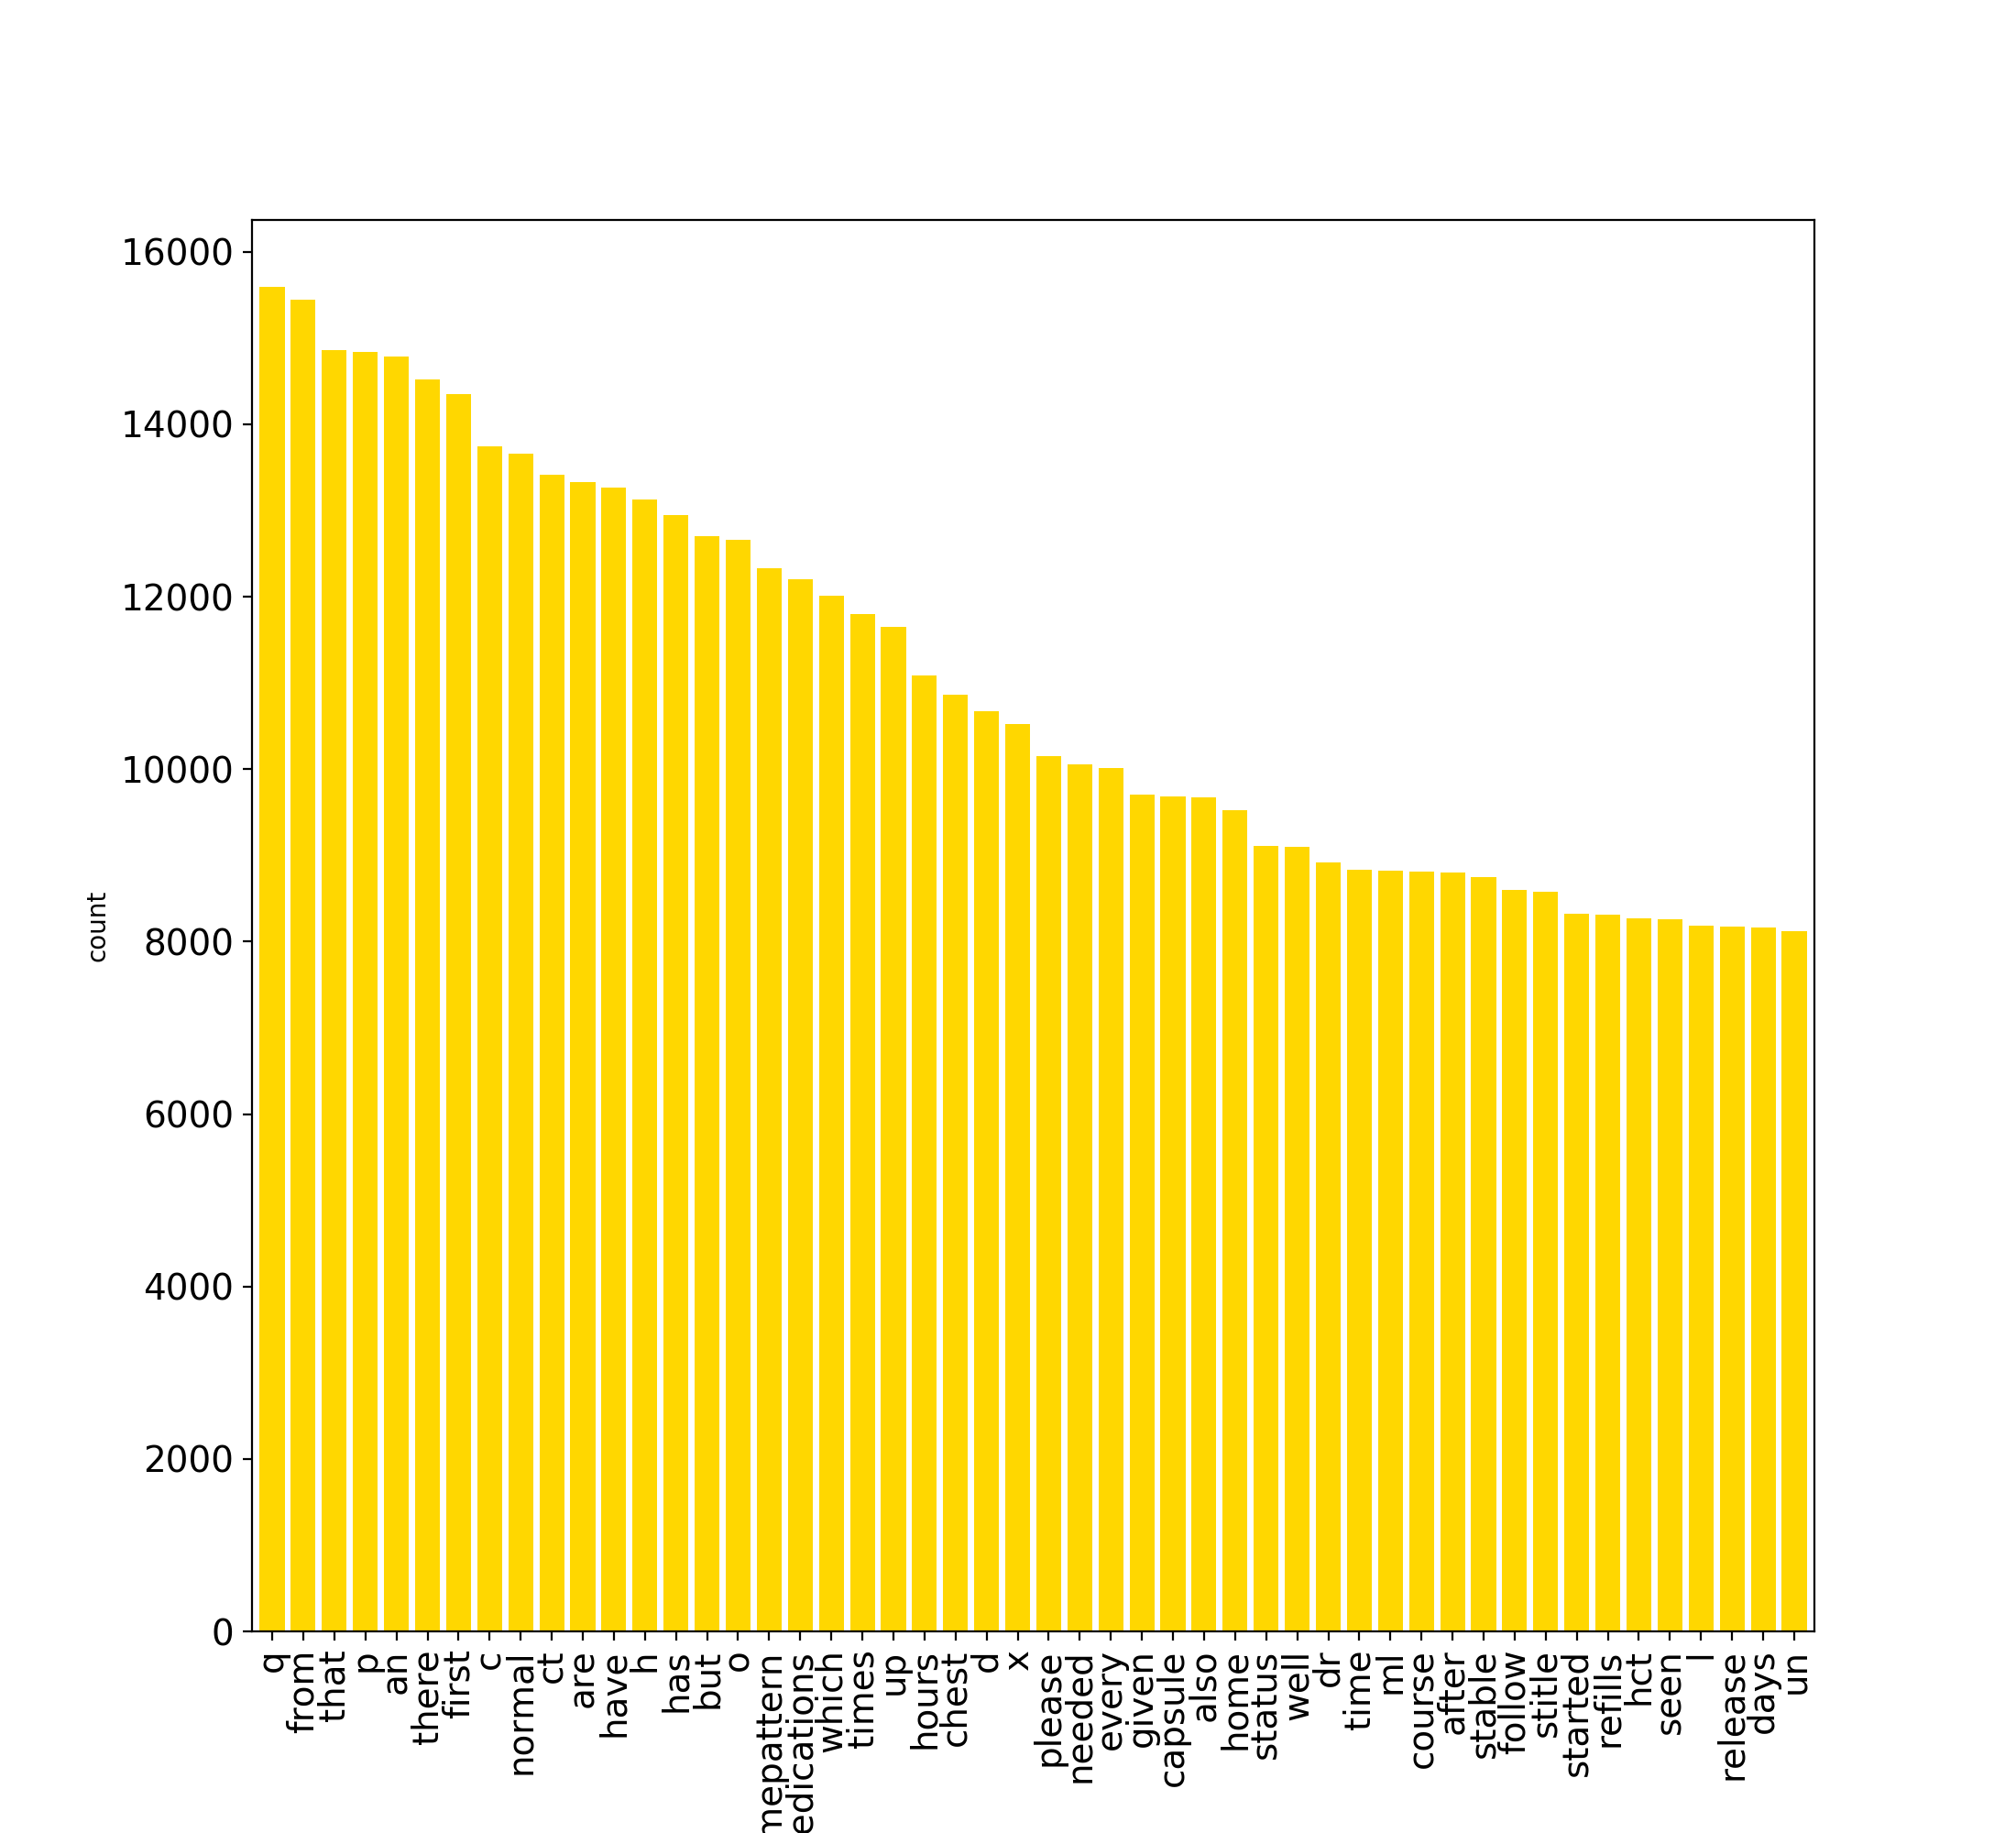

In [249]:
fig = plt.figure()
ax = d[50:100].plot(kind='bar', figsize=(11,10), width=.8, fontsize=14, rot=90,color = 'gold')
ax.title.set_size(18)
plt.ylabel('count')
plt.show()

In [250]:
some_stop_words = ['name','is','patient','s','he','at','as','or','one','she','his','her','am','were','you','pt','pm','by','be','had','your','this','date','from','there','an','that','p','are','have','has','h','but','o', 'namepattern','which','every','also']

In [251]:
vect = CountVectorizer(max_features = 4000, tokenizer = tokenizer_2, stop_words = some_stop_words)
vect.fit(df_train.TEXT.values)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=4000, min_df=1,
                ngram_range=(1, 1), preprocessor=None,
                stop_words=['name', 'is', 'patient', 's', 'he', 'at', 'as',
                            'or', 'one', 'she', 'his', 'her', 'am', 'were',
                            'you', 'pt', 'pm', 'by', 'be', 'had', 'your',
                            'this', 'date', 'from', 'there', 'an', 'that', 'p',
                            'are', 'have', ...],
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function tokenizer_2 at 0x1255df268>,
                vocabulary=None)

In [252]:
X_train_tf = vect.transform(df_train.TEXT.values)
X_valid_tf = vect.transform(df_valid.TEXT.values)

In [253]:
y_train = df_train.CHECK
y_valid = df_valid.CHECK

## Model

In [254]:
clf = LogisticRegression(C = 0.0001, penalty = 'l2', random_state = 42)
clf.fit(X_train_tf, y_train)

/Users/harnoor_dhingra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.0001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [255]:
model = clf
y_train_preds = model.predict_proba(X_train_tf)[:,1]
y_valid_preds = model.predict_proba(X_valid_tf)[:,1]

In [256]:
print(y_train[:10].values)
print(y_train_preds[:10])

[1 1 0 1 1 1 0 0 1 1]
[0.77969299 0.65977518 0.29107497 0.7904965  0.61670842 0.5236303
 0.37179017 0.91322733 0.47213906 0.71312368]


## Performance Metrics

In [257]:
def calc_specificity(y_actual, y_pred, thresh):
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

In [258]:
def calc_prevalence(y_actual):
    return sum((y_actual == 1)) /len(y_actual)

In [259]:
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)
thresh = 0.5
auc_train = roc_auc_score(y_train, y_train_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)

In [260]:
print('Train Prevalence:%.3f'%calc_prevalence(y_train))
print('Valid Prevalence:%.3f'%calc_prevalence(y_valid))

Train Prevalence:0.500
Valid Prevalence:0.057


In [261]:
print('Train AUC:%.3f'%auc_train)
print('Valid AUC:%.3f'%auc_valid)

Train AUC:0.759
Valid AUC:0.702


In [262]:
print('Train Accuracy:%.3f'%accuracy_score(y_train, y_train_preds >= thresh))
print('Valid Accuracy:%.3f'%accuracy_score(y_valid, y_valid_preds >= thresh))

Train Accuracy:0.700
Valid Accuracy:0.671


In [263]:
print('Train Recall:%.3f'%recall_score(y_train, y_train_preds>= thresh))
print('Valid Recall:%.3f'%recall_score(y_valid, y_valid_preds>= thresh))

Train Recall:0.674
Valid Recall:0.636


In [264]:
print('Train Precision:%.3f'%precision_score(y_train, y_train_preds>= thresh))
print('Valid Precision:%.3f'%precision_score(y_valid, y_valid_preds>= thresh))

Train Precision:0.710
Valid Precision:0.105


In [265]:
print('Train Specificity:%.3f'%calc_specificity(y_train, y_train_preds, thresh))
print('Valid Specificity:%.3f'%calc_specificity(y_valid, y_valid_preds, thresh))

Train Specificity:0.725
Valid Specificity:0.673


<IPython.core.display.Javascript object>


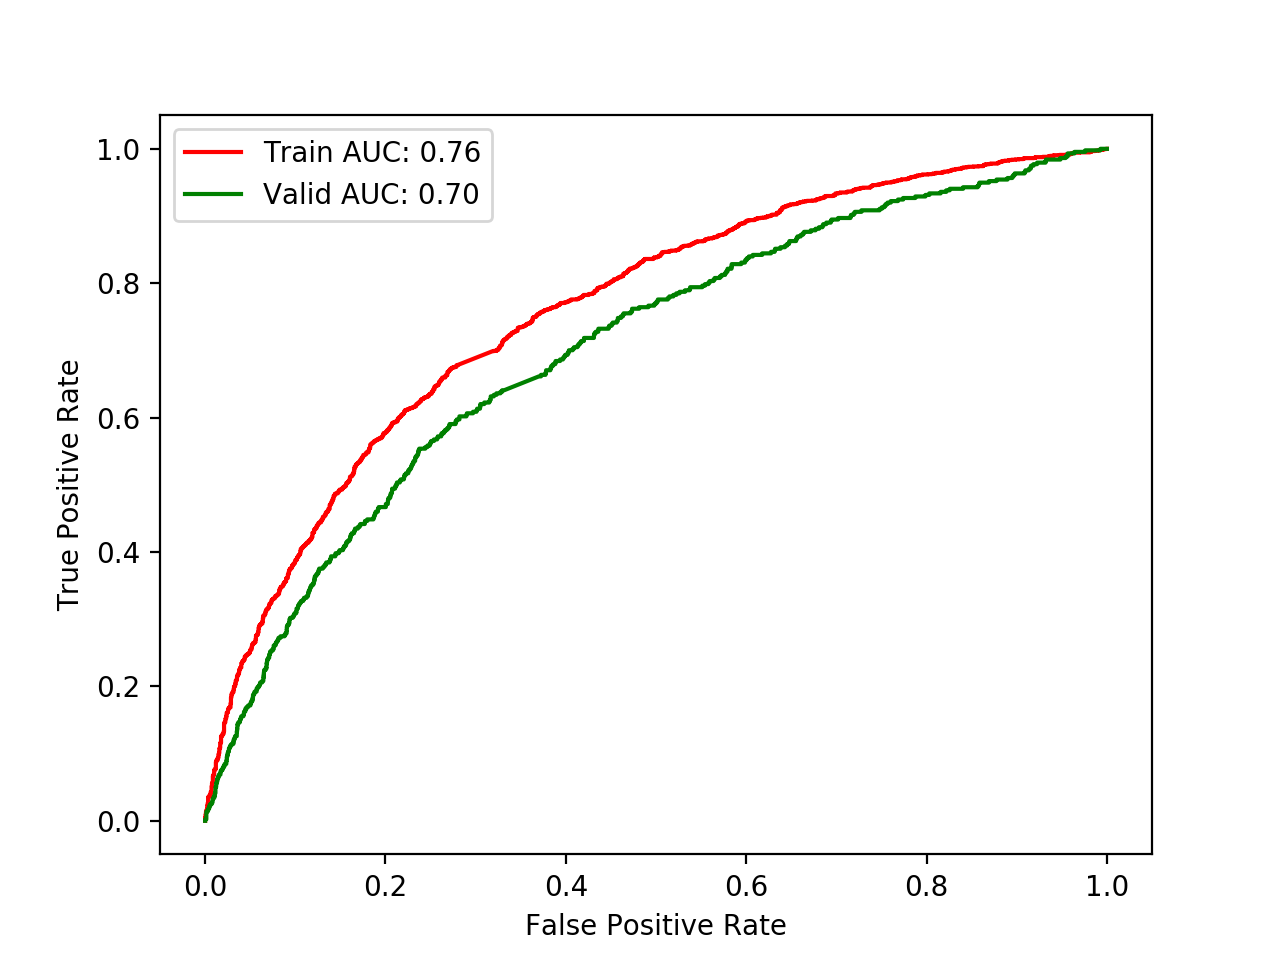

In [267]:
fig = plt.figure()
plt.plot(fpr_train, tpr_train,'r-', label = 'Train AUC: %.2f'%auc_train)
plt.plot(fpr_valid, tpr_valid,'g-',label = 'Valid AUC: %.2f'%auc_valid)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.xticks()
plt.yticks()
plt.show()

In [268]:
feature_importances = pd.DataFrame(clf.coef_[0],index = vect.get_feature_names(),columns=['importance']).sort_values('importance',ascending=False)

<IPython.core.display.Javascript object>


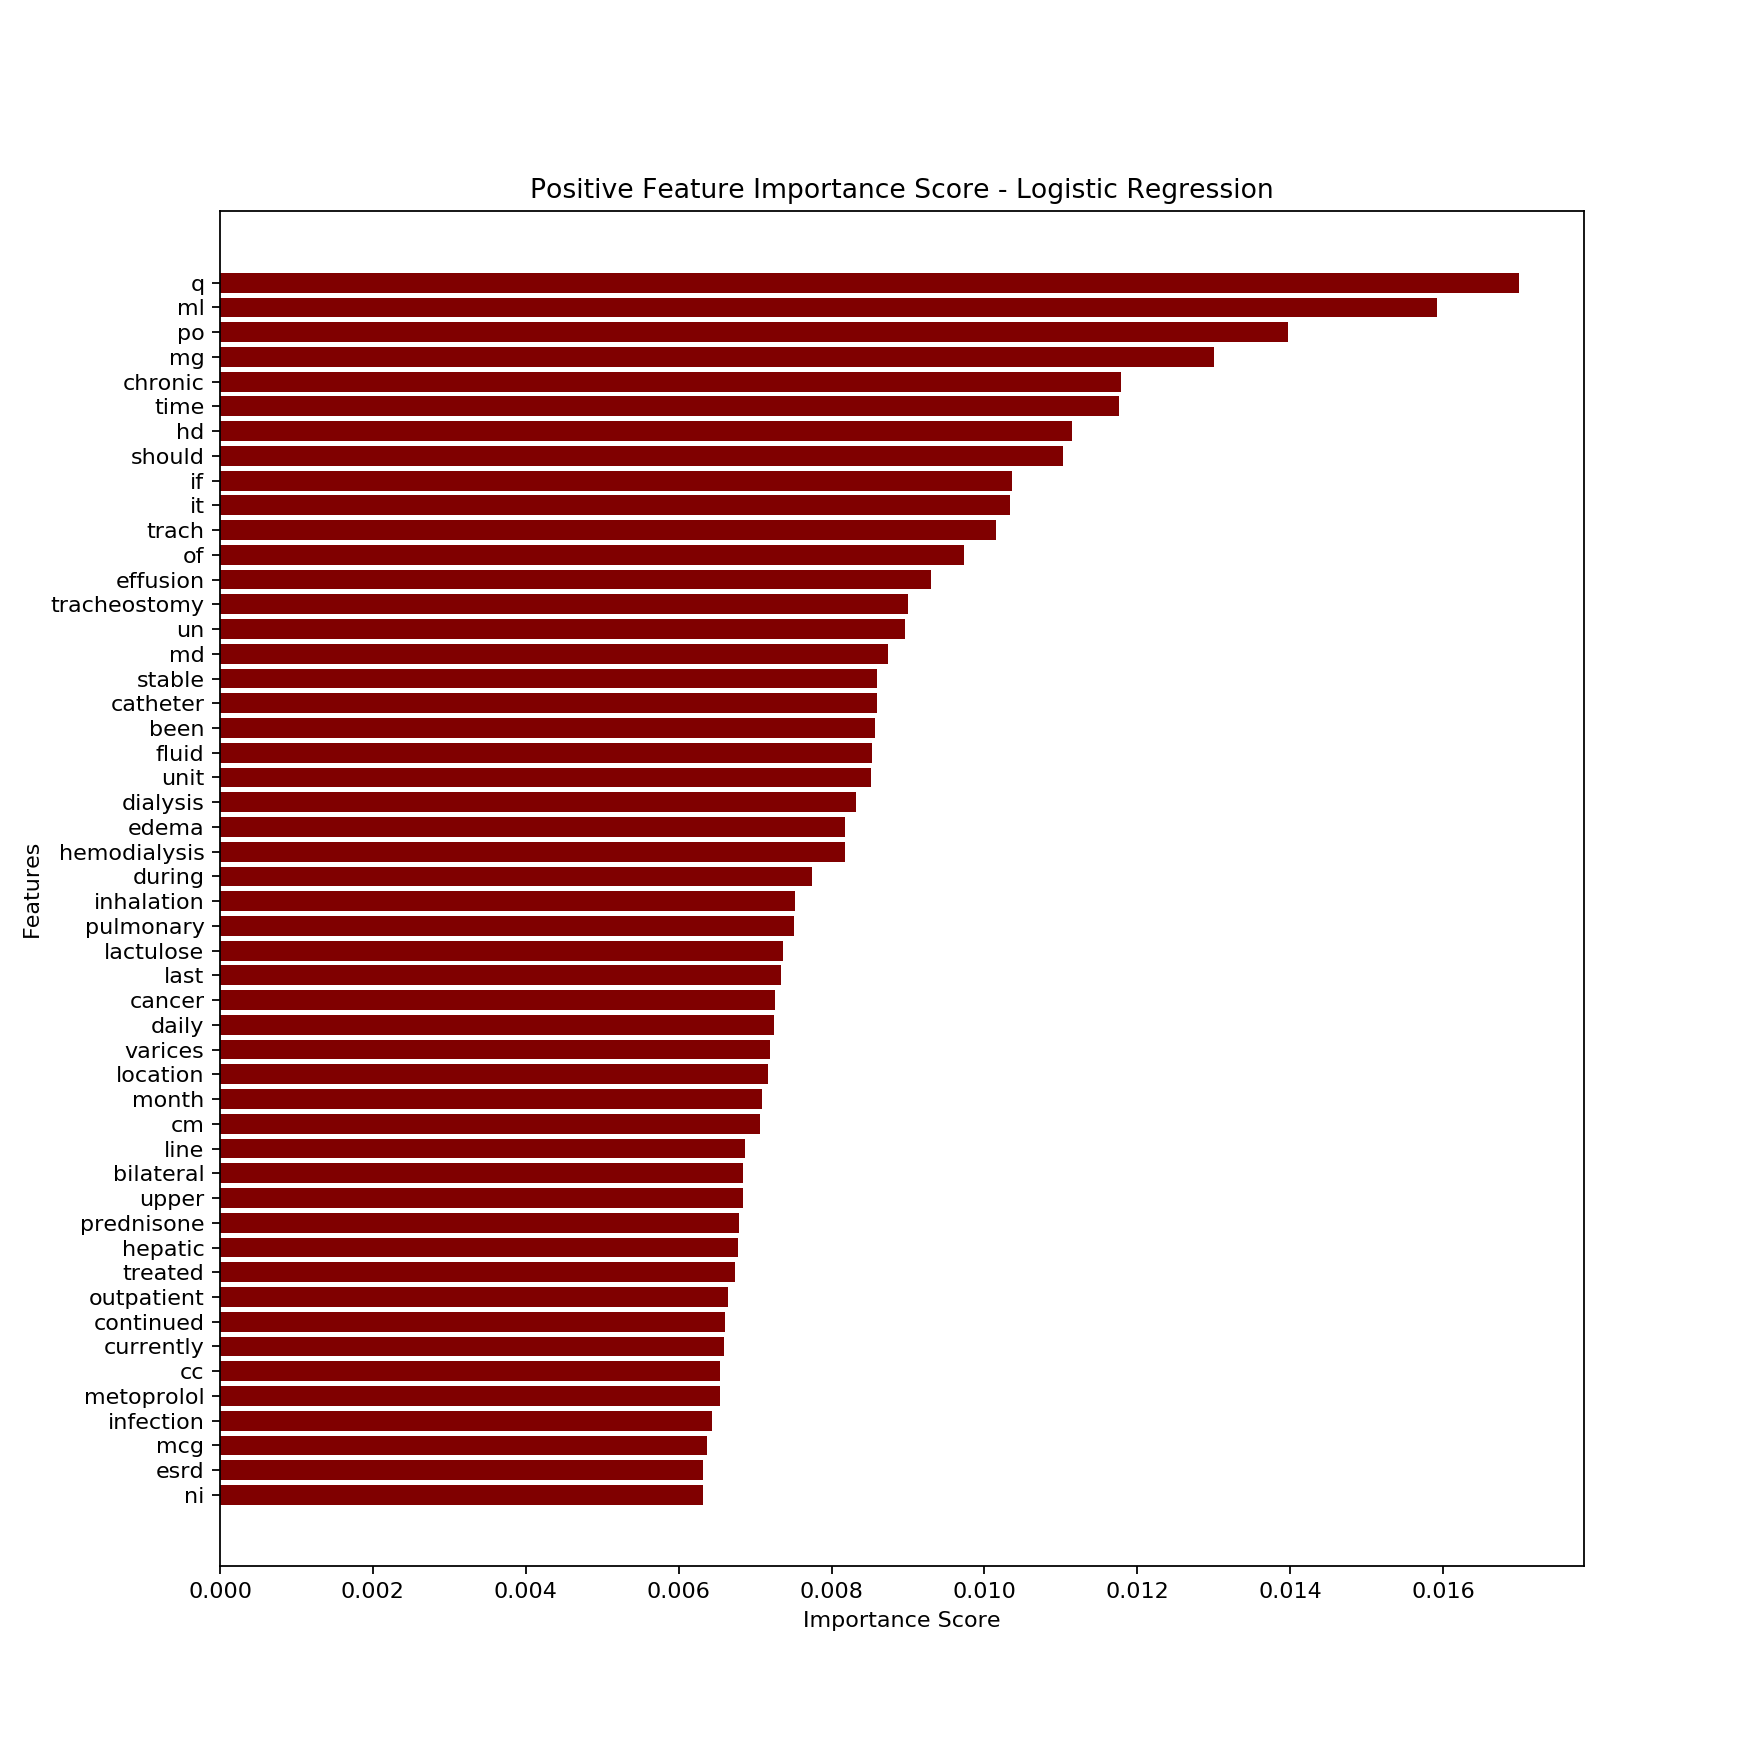

In [269]:
num = 50
ylocs = np.arange(num)
values_to_plot = feature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(feature_importances.iloc[:num].index)[::-1]
plt.figure(num=None, figsize=(11, 11), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center', color = 'maroon')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Positive Feature Importance Score - Logistic Regression')
plt.yticks(ylocs, feature_labels)
plt.show()

<IPython.core.display.Javascript object>


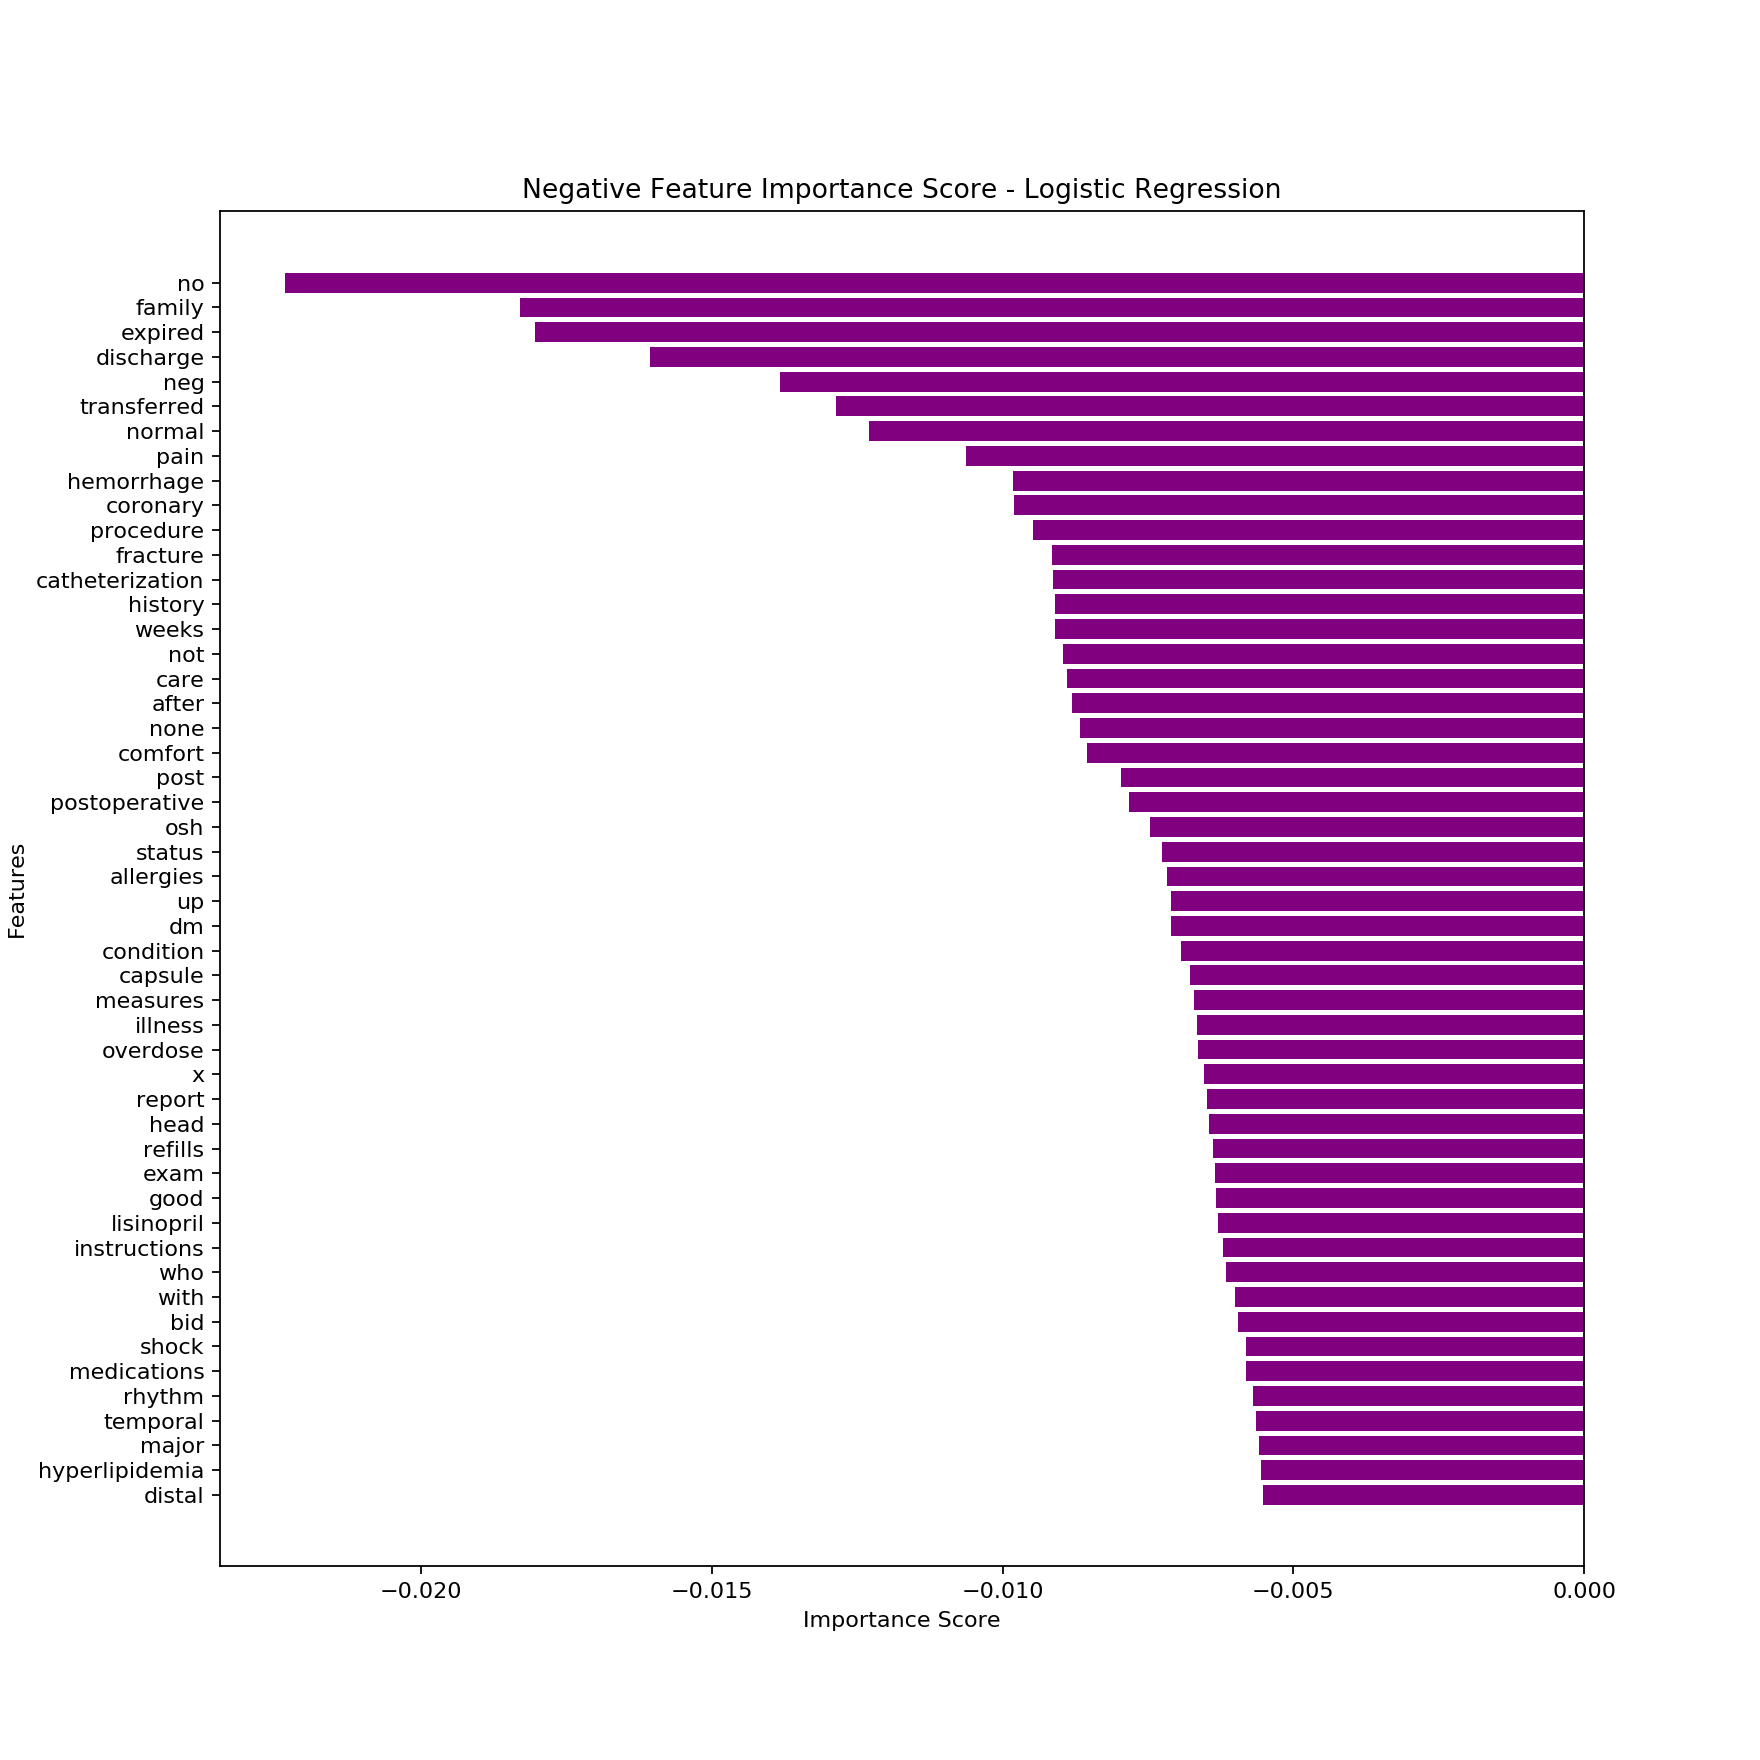

In [270]:
values_to_plot = feature_importances.iloc[-num:].values.ravel()
feature_labels = list(feature_importances.iloc[-num:].index)
plt.figure(num=None, figsize=(11, 11), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center', color = 'purple')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Negative Feature Importance Score - Logistic Regression')
plt.yticks(ylocs, feature_labels)
plt.show()

In [271]:
more_stop_words = ['the','was','with','a','on','in','for','name','is','patient','s','he','at','as','or','one','she','his','her','am','were','you','pt','pm','by','be','had','your','this','date','from','there','an','that','p','are','have','has','h','but','o','namepattern','which','every','also','should','if','it','been','who','during', 'x']

In [272]:
vect = CountVectorizer(lowercase = True, max_features = 4000, tokenizer = tokenizer_two,stop_words = more_stop_words)

In [273]:
vect.fit(df_train.TEXT.values)
X_train_tf = vect.transform(df_train.TEXT.values)
X_valid_tf = vect.transform(df_valid.TEXT.values)
y_train = df_train.CHECK
y_valid = df_valid.CHECK

## Hyperparameter Tuning

In [274]:
Cs = [0.00002, 0.00005, 0.0002, 0.0004, 0.002, 0.006]
train_aucs = np.zeros(len(Cs))
valid_aucs = np.zeros(len(Cs))
for ii in range(len(Cs)):
    C = Cs[ii]
    print('C:', C)
    clf=LogisticRegression(C = C, penalty = 'l2', random_state = 42)
    clf.fit(X_train_tf, y_train)
    model = clf
    y_train_preds = model.predict_proba(X_train_tf)[:,1]
    y_valid_preds = model.predict_proba(X_valid_tf)[:,1]
    auc_train = roc_auc_score(y_train, y_train_preds)
    auc_valid = roc_auc_score(y_valid, y_valid_preds)
    print('Train AUC:%.4f'%auc_train)
    print('Valid AUC:%.4f'%auc_valid)
    train_aucs[ii] = auc_train
    valid_aucs[ii] = auc_valid

C: 2e-05
Train AUC:0.7158
Valid AUC:0.6857
C: 5e-05


/Users/harnoor_dhingra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/harnoor_dhingra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train AUC:0.7371
Valid AUC:0.6956
C: 0.0002


/Users/harnoor_dhingra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train AUC:0.7821
Valid AUC:0.7117
C: 0.0004


/Users/harnoor_dhingra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train AUC:0.8135
Valid AUC:0.7174
C: 0.002


/Users/harnoor_dhingra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train AUC:0.8958
Valid AUC:0.7126
C: 0.006


/Users/harnoor_dhingra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train AUC:0.9452
Valid AUC:0.6949


<IPython.core.display.Javascript object>


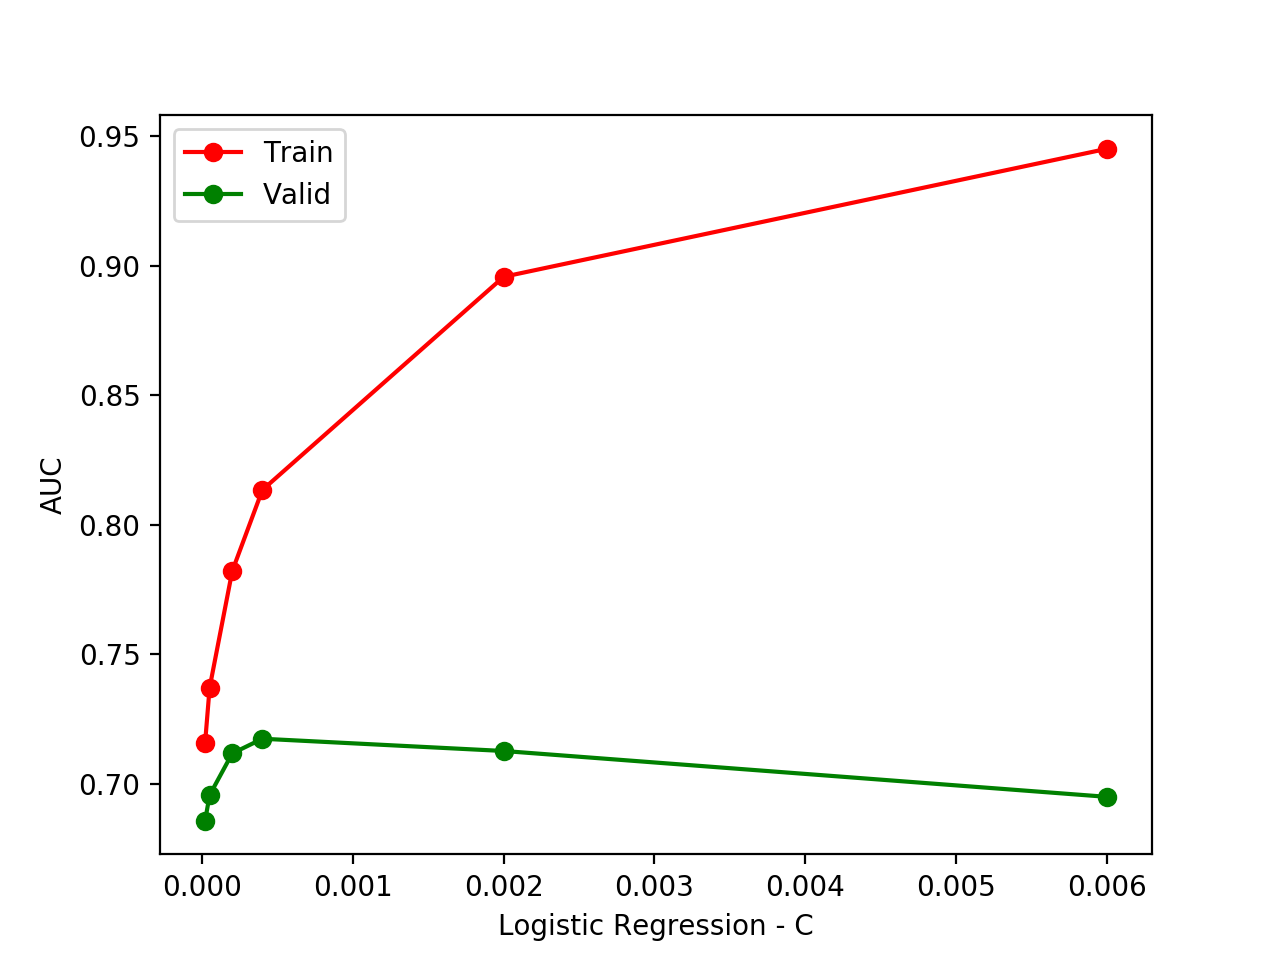

In [275]:
fig = plt.figure()
plt.plot(Cs, train_aucs,'ro-', label ='Train')
plt.plot(Cs, valid_aucs, 'go-', label='Valid')
plt.legend()
plt.xlabel('Logistic Regression - C')
plt.ylabel('AUC')
plt.show()

In [277]:
num_features = [100,300,1000,3000,10000,30000]
train_aucs = np.zeros(len(num_features))
valid_aucs = np.zeros(len(num_features))
for ii in range(len(num_features)):
    num = num_features[ii]
    print('number of features:', num)
    vect = CountVectorizer(lowercase = True, max_features = num, tokenizer = tokenizer_two,stop_words = more_stop_words)
    vect.fit(df_train.TEXT.values)
    X_train_tf = vect.transform(df_train.TEXT.values)
    X_valid_tf = vect.transform(df_valid.TEXT.values)
    y_train = df_train.CHECK
    y_valid = df_valid.CHECK
    clf=LogisticRegression(C = 0.0001, penalty = 'l2', random_state = 42)
    clf.fit(X_train_tf, y_train)
    model = clf
    y_train_preds = model.predict_proba(X_train_tf)[:,1]
    y_valid_preds = model.predict_proba(X_valid_tf)[:,1]
    auc_train = roc_auc_score(y_train, y_train_preds)
    auc_valid = roc_auc_score(y_valid, y_valid_preds)
    print('Train AUC: %.3f'%auc_train)
    print('Valid AUC:%.3f'%auc_valid)
    train_aucs[ii] = auc_train
    valid_aucs[ii] = auc_valid

number of features: 100


/Users/harnoor_dhingra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train AUC: 0.689
Valid AUC:0.665
number of features: 300


/Users/harnoor_dhingra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train AUC: 0.715
Valid AUC:0.683
number of features: 1000


/Users/harnoor_dhingra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train AUC: 0.738
Valid AUC:0.697
number of features: 3000


/Users/harnoor_dhingra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train AUC: 0.755
Valid AUC:0.704
number of features: 10000


/Users/harnoor_dhingra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train AUC: 0.761
Valid AUC:0.704
number of features: 30000


/Users/harnoor_dhingra/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train AUC: 0.761
Valid AUC:0.704


<IPython.core.display.Javascript object>


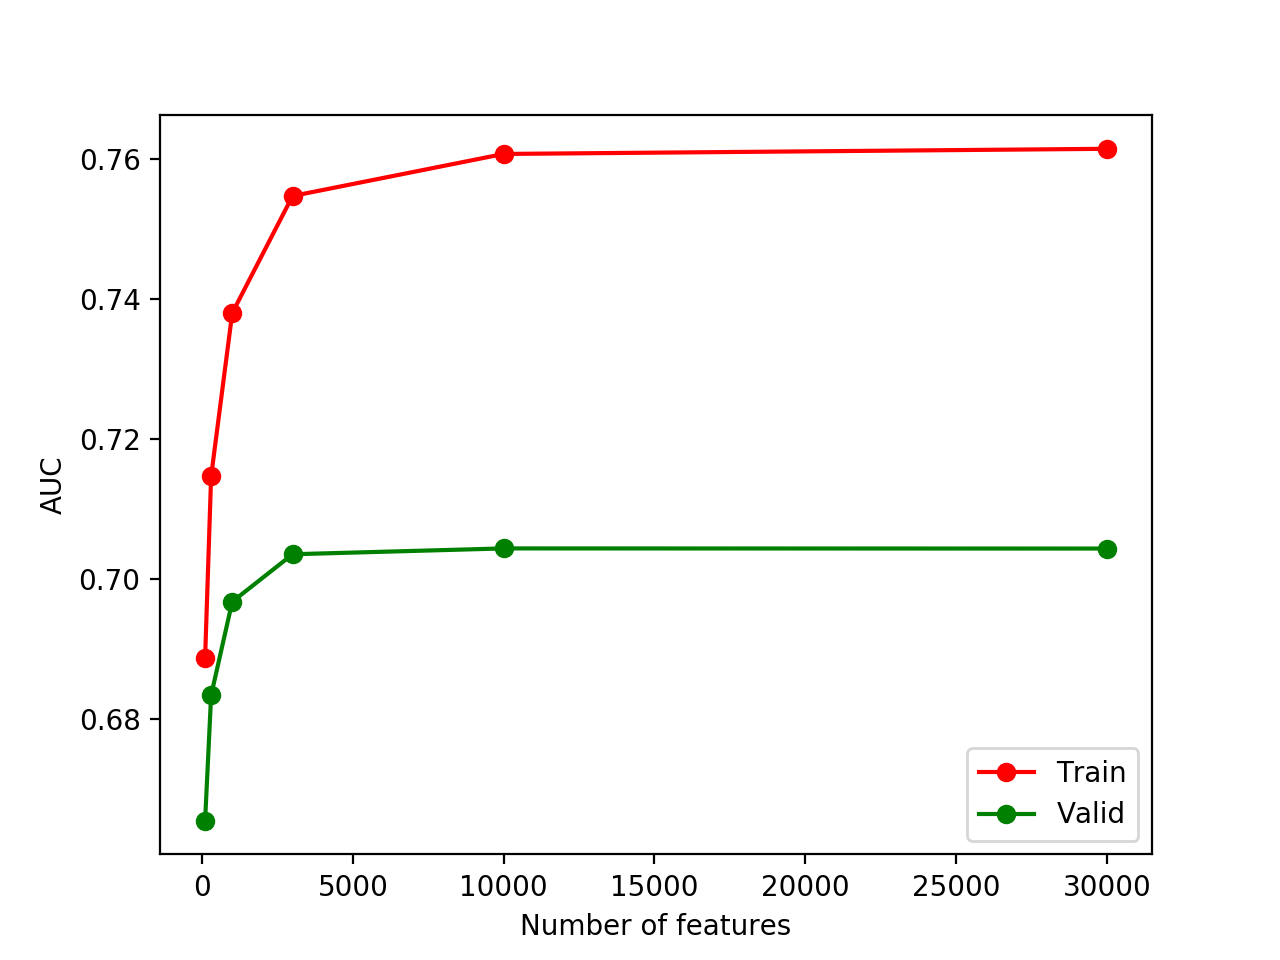

In [278]:
fig = plt.figure()
plt.plot(num_features, train_aucs,'ro-', label ='Train')
plt.plot(num_features, valid_aucs, 'go-', label='Valid')
plt.legend()
plt.xlabel('Number of features')
plt.ylabel('AUC')
plt.show()